In [1]:
%load_ext autoreload
%autoreload 2

# UMM Discovery

In [2]:
# %env HTTPS_PROXY = http://proxy-server.bms.com:8080

## Import libraries

In [3]:
# Check for GPU device
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'


In [4]:

print(os.getenv('CUDA_VISIBLE_DEVICES'))

0


In [5]:
# from numba.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning, NumbaPerformanceWarning
# import warnings

# warnings.filterwarnings(action='once')
# warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
# warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
# warnings.simplefilter('ignore', category=NumbaPerformanceWarning)
# warnings.simplefilter("ignore", category=PendingDeprecationWarning)

In [6]:
import os
import shutil
import time
import pandas as pd
import numpy as np

from sklearn.metrics.cluster import normalized_mutual_info_score

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchsummary import summary

import matplotlib.pyplot as plt

import clustering
from model import MultiScaleNet
from util import Logger, UnifLabelSampler
from training import compute_features, train
from correction import do_batch_correction
from evaluation import evaluate_epoch, evaluate_training
from my_dataset import bbbc021_dataset
from plot import plot_training, plot_training_summary, plot_inter_part_validation, plot_inter_hier_validation, plot_external_validation, plot_NSC_NSB, plot_total_score

c:\Users\marfok\OneDrive - Bristol Myers Squibb\Desktop\Archetecture 2.0\DSAA\HCS\Unsupervised\UMM-Discovery\_venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set parameter

In [7]:
# dataset = bbbc021_dataset(args.data, args.csv, 'pseudoclass', transform=transforms.Compose(tra))

In [8]:
class args:
    # Experiment ID
    run_ID = "EXP01"
    
    # path to dataset
    data = os.getcwd()#"/path/to/dataset"
    
    # file name of the metadata csv file
    # csv = "dataset.csv"
    csv = "pivoted_channelID_data.csv"
    
    # path to the output folder
    save_path = "/path/to/output/folder/"
    output_path = "" #dont assign

    # CNN architecture 
    arch = "msnet" 

    # input channels
    n_input_dim = 2
    
    # number of features
    n_features = 64
    # n_features = 96
    
    # Batch correction ["TVN", "COMBAT", MNN]
    # batch_corrections = ["COMBAT", "TVN"] 
    batch_corrections = None
    
    # dimension reduction method (default: PCA)
    # 'PCA' or 'UMAP' or 'TSNE' or 'AdaptiveTSNE'
    dim_method = 'PCA' 
    
    # dimensions after reduction
    n_components = 16
    
    # clustering algorithm (default: Kmeans)
    # 'Kmeans' or 'AdaptiveKmeans' or 'PIC' or 'HDBscan' 
    clustering = 'Kmeans'

    # number of cluster for k-means (default: 10000)
    # nmb_cluster = 104
    nmb_cluster = 90
    
    # parameter for adaptive k-means
    end_k = 39
    end_epochs = 150
    
    # parameter for PIC
    sigma = 0.2 
    nnn = 5
    
    # paramter for HDBscan
    min_cluster_size = 12
    min_samples = 3
    nnn = 25
    
    # mini-batch size (default: 256)
    # batch = 16
    batch = 4
    
    # learning rate (default: 0.05)
    lr = 0.05
    
    # weight decay pow (default: -5)
    wd=-5
    
    # number of total epochs to run (default: 200)
    epochs = 50

    # momentum (default: 0.9)
    momentum = 0.9

    # how many epochs of training between two consecutive reassignments of clusters (default: 1)
    reassign = 1

    # number of data loading workers (default: 4)
    workers=4
    
    # cuda version
    # cuda = 10
    cuda = 0
    
    # Epoch to continue from (default: None)
    resume = None
    
    # manual epoch number (useful on restarts) (default: 0)
    start_epoch = 0
    
    # random seed (default: 42)
    seed = 12
    
    # chatty
    verbose = True

In [9]:
torch.cuda.is_available()

True

In [10]:
torch.cuda.current_device()

0

In [11]:
torch.cuda.get_device_name(0)

'T500'

In [12]:
torch.cuda.memory_cached()

c:\Users\marfok\OneDrive - Bristol Myers Squibb\Desktop\Archetecture 2.0\DSAA\HCS\Unsupervised\UMM-Discovery\_venv\lib\site-packages\torch\cuda\memory.py:397: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


0

In [13]:
torch.cuda.memory_allocated()

0

In [14]:
exp_name = ""
exp_name +='{}_'.format(args.run_ID)

## Add clustering algorithm
if args.clustering == "Kmeans":
    clustering_parameter = 'Kmeans_cl{}'.format(args.nmb_cluster)
elif args.clustering == "AdaptiveKmeans":
    clustering_parameter = 'AdaptiveKmeans_cl{}-{}_ep{}'.format(args.nmb_cluster, args.end_k, args.end_epochs)
elif args.clustering == "PIC":
    clustering_parameter = 'PIC_sig{}_nn{}'.format(args.sigma, args.nnn)
elif args.clustering == "HDBscan":
    clustering_parameter = 'HDBscan_mincl{}-minsam{}_nn{}'.format(args.min_cluster_size, args.min_samples, args.nnn)

exp_name +='{}'.format(clustering_parameter)
    
## Add dimensionality reduction method
exp_name +='_{}-{}d'.format(args.dim_method, args.n_components)

## Add batch correction
batch_corrections_parameter = None
if args.batch_corrections == None:
    batch_corrections_parameter = "NoCorrection"
else:
    for corr in args.batch_corrections:
        if batch_corrections_parameter is None:
            batch_corrections_parameter = corr
        else:
            batch_corrections_parameter +='_{}'.format(corr)
exp_name +='_{}'.format(batch_corrections_parameter)
    
print('Experiment: {}'.format(exp_name))

Experiment: EXP01_Kmeans_cl90_PCA-16d_NoCorrection


In [15]:
args.output_path = os.path.join(args.save_path, exp_name)
print('Output path: {}'.format(args.output_path))

Output path: /path/to/output/folder/EXP01_Kmeans_cl90_PCA-16d_NoCorrection


In [16]:
embed_path = os.path.join(args.output_path, 'y-embed_{}.txt'.format(exp_name))
metadata_path = os.path.join(args.output_path, 'metadata_{}.txt'.format(exp_name))
assign_epoch_path = os.path.join(args.output_path, 'epoch_assignment_{}.txt'.format(exp_name))
metrices_path = os.path.join(args.output_path, 'metrices_{}.txt'.format(exp_name))
loss_path = os.path.join(args.output_path, 'loss_{}.txt'.format(exp_name))

best_labeled_sil_embed_path = os.path.join(args.output_path, 'best_labeled_sil_y-embed_{}.txt'.format(exp_name))
best_labeled_nsc_embed_path = os.path.join(args.output_path, 'best_labeled_nsc_y-embed_{}.txt'.format(exp_name))
best_unlabeled_embed_path = os.path.join(args.output_path, 'best_unlabeled_y-embed_{}.txt'.format(exp_name))

In [17]:
embeds_cols = ['Z{:03d}'.format(i) for i in range(args.n_features)]

## Create Neural Network

In [18]:
# fix random seeds
torch.manual_seed(args.seed)
#torch.cuda.manual_seed_all(args.seed)
np.random.seed(args.seed)

# CNN
if args.verbose:
    print('Create Multi-Scale Neural Network')
    
model = MultiScaleNet(input_dim=2, num_features=args.n_features, num_classes=args.nmb_cluster)
fd = int(model.top_layer.weight.size()[1])
model.top_layer = None
model.features = torch.nn.DataParallel(model.features)
model.cuda()
cudnn.benchmark = True

# create optimizer
optimizer = torch.optim.SGD(
    filter(lambda x: x.requires_grad, model.parameters()),
    lr=args.lr,
    momentum=args.momentum,
    weight_decay=10**args.wd,
)

# define loss function
criterion = nn.CrossEntropyLoss().cuda()

# optionally resume from a checkpoint
if args.resume:
    checkpoint_path = os.path.join(args.output_path, 'checkpoints', 'checkpoint_epoch{}.pth.tar'.format(args.resume))
    if os.path.isfile(checkpoint_path):
        print("=> loading checkpoint '{}'".format(checkpoint_path))
        checkpoint = torch.load(checkpoint_path)
        args.start_epoch = checkpoint['epoch']
        # remove top_layer parameters from checkpoint
        for key in list(checkpoint['state_dict']):
            if 'top_layer' in key:
                del checkpoint['state_dict'][key]
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint '{}' (epoch {})"
              .format(args.resume, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(args.resume))

# creating checkpoint repo
exp_check = os.path.join(args.output_path, 'checkpoints')
if not os.path.isdir(exp_check):
    os.makedirs(exp_check)

# creating cluster assignments log
cluster_log = Logger(os.path.join(args.output_path, 'train_data.pkl'))
if args.resume:
    cluster_log.load_data(args.resume)

Create Multi-Scale Neural Network


In [19]:
# if args.verbose:
#     summary(model, input_size=(2, 512, 640))

In [20]:
if args.cuda==10:
    # create tensorboard writer
    tensorboard_path = os.path.join(args.save_path, 'runs', exp_name)

    if os.path.isdir(tensorboard_path) and not args.resume:
        shutil.rmtree(tensorboard_path)

    if not os.path.isdir(tensorboard_path):
        os.makedirs(tensorboard_path)
    
    from torch.utils.tensorboard import SummaryWriter
    tensorboard_writer = SummaryWriter(log_dir=tensorboard_path)
else:
    tensorboard_writer = None

## Load the data

In [21]:
tra = [transforms.ToTensor()]
    
# load the data
end = time.time()

dataset = bbbc021_dataset(args.data, args.csv, 'pseudoclass', transform=transforms.Compose(tra))

if args.verbose: 
    print('Load dataset: {0:.2f} s'.format(time.time() - end))
    
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=args.batch,
                                         num_workers=args.workers,
                                         pin_memory=True)

Load dataset: 0.02 s


### Check data

In [22]:
dataset.get_df().head()

,Unnamed: 0,id_HOECHST,State,Row,Col,ChannelID_HOECHST,FieldID,PlaneID,TimepointID,SequenceID,...,compound,compound_uM,table_nr,pseudoclass,id_mCHERRY,mCHERRY_IMAGE,ChannelID_mCHERRY,plate,rel_dose_adjust,batch
0,0,0122K1F1P1R1,NaN,1,22,1,1,1,1,1,...,POS-000001,uM,Blank,class_0,0122K1F1P1R2,r01c22-2111396476.tiff,2,PTL-000001,0,Batch_Blank
1,1,0122K1F2P1R1,NaN,1,22,1,2,1,1,1,...,POS-000001,uM,Blank,class_2,0122K1F1P1R2,r01c22-2111396476.tiff,2,PTL-000001,0,Batch_Blank
2,2,0122K1F3P1R1,NaN,1,22,1,3,1,1,1,...,POS-000001,uM,Blank,class_4,0122K1F1P1R2,r01c22-2111396476.tiff,2,PTL-000001,0,Batch_Blank
3,3,0222K1F1P1R1,NaN,2,22,1,1,1,1,1,...,POS-000001,uM,Blank,class_6,0222K1F1P1R2,r02c22-2137399416.tiff,2,PTL-000001,0,Batch_Blank
4,4,0222K1F2P1R1,NaN,2,22,1,2,1,1,1,...,POS-000001,uM,Blank,class_8,0222K1F1P1R2,r02c22-2137399416.tiff,2,PTL-000001,0,Batch_Blank


In [23]:
print('Number of compounds: {}'.format(len(dataset.get_df()['compound'].unique())))
print('Number of treatments: {}'.format(len(dataset.get_df()['pseudoclass'].unique())))

Number of compounds: 1
Number of treatments: 48


In [24]:
dataset.get_df().shape

(48, 26)

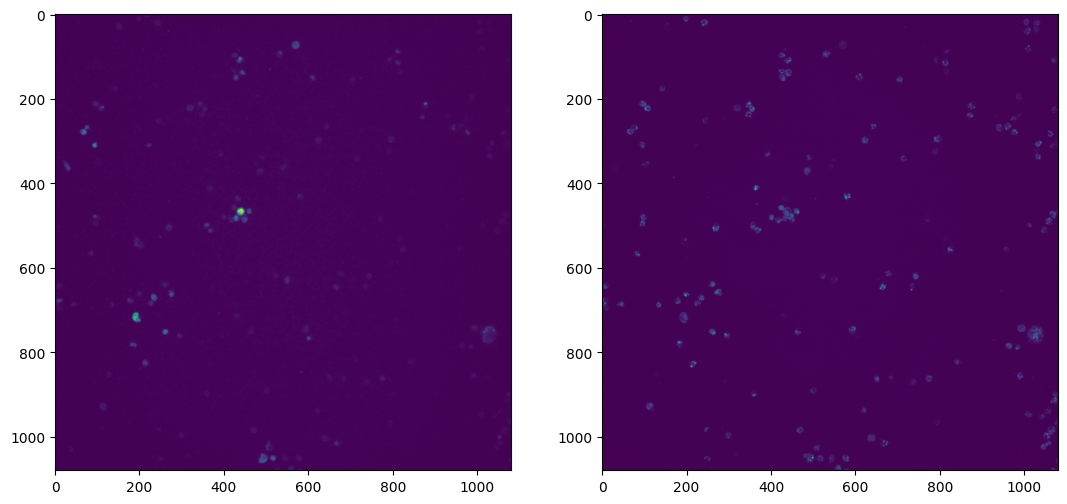

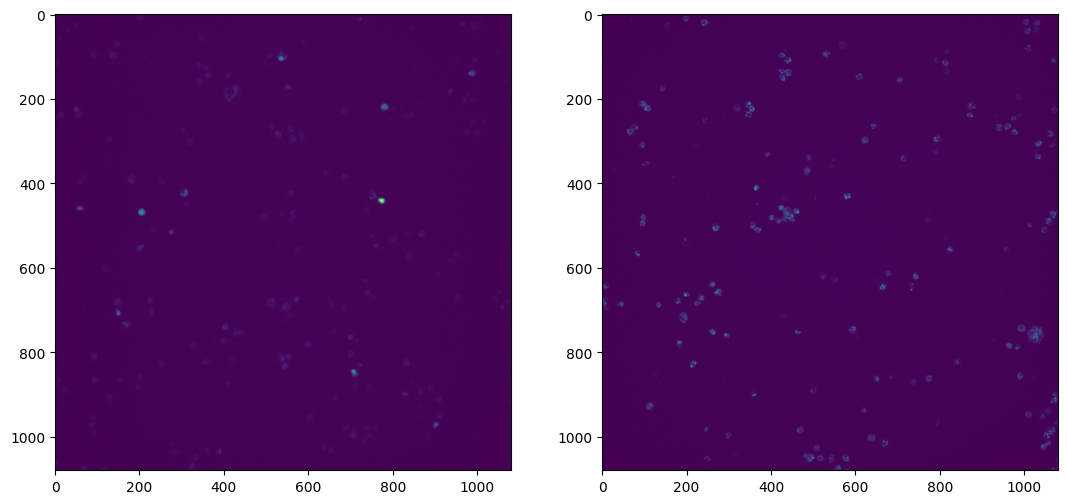

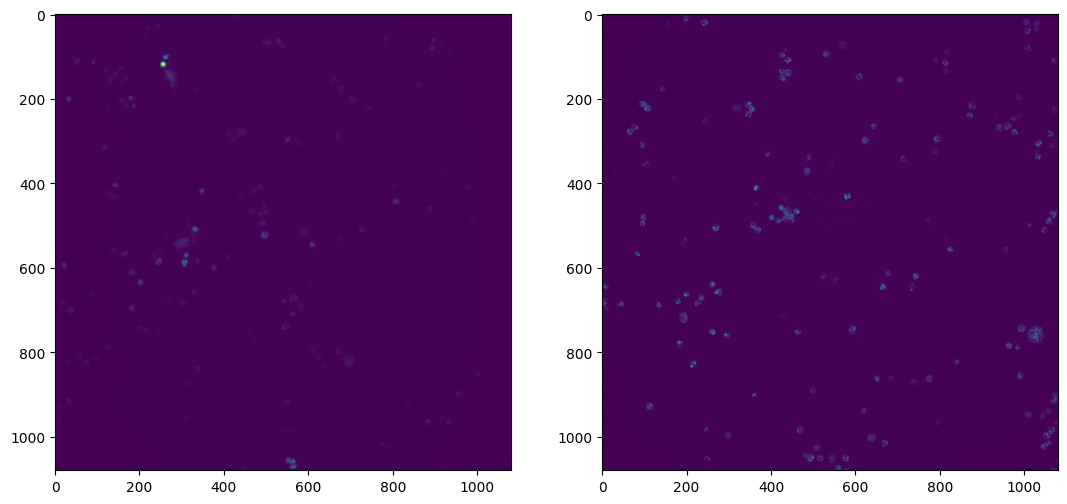

In [25]:
for i in range(3):
    img = dataset[i][0]

    plt.figure(figsize=(20,10))
    ax = plt.subplot(1, 3, 1)
    plt.imshow(img[0,:,:])
    
    ax = plt.subplot(1, 3, 2)
    plt.imshow(img[1,:,:])
    
    # ax = plt.subplot(1, 3, 3)
    # plt.imshow(img[2,:,:])

    plt.show()

In [26]:
img[1,:,:].size()

torch.Size([1080, 1080])

In [27]:
img.size()

torch.Size([2, 1080, 1080])

## Setup clustering algorithm

In [28]:
# clustering algorithm to use
if args.clustering == "Kmeans":
    deepcluster = clustering.Kmeans(k=args.nmb_cluster, 
                                    dim_method=args.dim_method, 
                                    n_components=args.n_components,
                                    n_jobs=args.workers+1)
elif args.clustering == "AdaptiveKmeans":
    deepcluster = clustering.AdaptiveKmeans(initial_k=args.nmb_cluster, 
                                            end_k=args.end_k, 
                                            end_epochs=args.end_epochs, 
                                            initial_epoch=args.start_epoch, 
                                            dim_method=args.dim_method, 
                                            n_components=args.n_components,
                                            n_jobs=args.workers+1)
elif args.clustering == "PIC":
    deepcluster = clustering.PIC(sigma=args.sigma, 
                                 nnn=args.nnn, 
                                 dim_method=args.dim_method, 
                                 n_components=args.n_components,
                                 n_jobs=args.workers+1)
elif args.clustering == "HDBscan":
    deepcluster = clustering.HDBscan(min_cluster_size=args.min_cluster_size, 
                                    min_samples=args.min_samples, 
                                    nnn=args.nnn, 
                                    dim_method=args.dim_method, 
                                    n_components=args.n_components,
                                    n_jobs=args.workers+1)

## Train neural network

In [29]:
loss_list = []
nmi_list = [0]
best_NSC_acc = 0
df_meta = dataset.get_df()

In [30]:
len(dataloader)

12

In [31]:
im_lst = []
for i,img_tup in enumerate(dataloader):
    img, lbl = img_tup
    # print(f"Image {img}: \n{d}")
    # print(img.get_device())
    print(img.device)


cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu


In [37]:
len(embeds_cols)

64

In [35]:
# training convnet with DeepCluster
start_train_time = time.time()
for epoch in range(args.start_epoch, args.epochs):
    end = time.time()

    # remove head
    model.top_layer = None
    model.classifier = nn.Sequential(*list(model.classifier.children())[:-1])

    # compute features for the whole dataset
    features = compute_features(dataloader, model, len(dataset), args)
    print(features.shape)
    embeds = pd.DataFrame(features, columns=embeds_cols)
    embeds = pd.concat([df_meta, embeds], axis=1)
    
    # batch correction 
    embeds = do_batch_correction(embeds, embeds_cols, args.batch_corrections, verbose=args.verbose)
        
    # evaluate features
    df_eval = evaluate_epoch(embeds.copy(), embeds_cols, verbose=args.verbose)
    
    # best epoch
    NSC_acc = df_eval["NSC_1-NN_treatment"][0]
    if NSC_acc > best_NSC_acc:
        best_NSC_acc = NSC_acc
    
    # cluster the features
    clustering_loss = deepcluster.cluster(embeds[embeds_cols].to_numpy(copy=True), verbose=args.verbose)

    # save cluster assignment
    df_assign_epoch = pd.DataFrame(clustering.arrange_clustering(deepcluster.images_lists), columns=['Assignment_{}'.format(epoch)])

    # assign pseudo-labels
    train_dataset = clustering.cluster_assign(deepcluster.images_lists, dataset.imgs)

    # uniformely sample per target
    sampler = UnifLabelSampler(int(args.reassign * len(train_dataset)),
                               deepcluster.images_lists)

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=args.batch,
        num_workers=args.workers,
        sampler=sampler,
        pin_memory=True,
    )

    # set last fully connected layer
    mlp = list(model.classifier.children())
    mlp.append(nn.ReLU(inplace=True).cuda())
    model.classifier = nn.Sequential(*mlp)
    model.top_layer = nn.Linear(args.n_features, len(deepcluster.images_lists))
    model.top_layer.weight.data.normal_(0, 0.01)
    model.top_layer.bias.data.zero_()
    model.top_layer.cuda()

    # train network with clusters as pseudo-labels
    start_epoch_train_time = time.time()
    loss = train(train_dataloader, model, criterion, optimizer, epoch, args)
    loss_list.append(float(loss))

    # print log
    if args.verbose:
        print('###### Epoch [{0}] ###### \n'
              'Total Time: {1:.3f} s\n'
              'Training time: {2:.3f} s\n'
              'ConvNet loss: {3:.3f} \n'
              'NSC acc: {4:.3f} \n'
              'Silhoutte score: {5:.3f} \n'
              'Best NSC acc: {6:.3f}'
              .format(epoch, 
                      time.time() - end, 
                      time.time() - start_epoch_train_time, 
                      loss, 
                      df_eval["NSC_1-NN_treatment"][0]*100, 
                      df_eval["silhou_moa"][0],
                      best_NSC_acc*100
                     ))
        try:
            if epoch > 0:
                nmi = normalized_mutual_info_score(
                    clustering.arrange_clustering(deepcluster.images_lists),
                    clustering.arrange_clustering(cluster_log.data['clustering'][-1])
                )
                print('NMI against previous assignment: {0:.3f}'.format(nmi))
            else:
                nmi = 0
            nmi_list.append(nmi)
        except IndexError:
            pass
        print('####################### \n')
    # save running checkpoint
    torch.save({'epoch': epoch + 1,
                'arch': args.arch,
                'state_dict': model.state_dict(),
                'optimizer' : optimizer.state_dict()},
               os.path.join(args.output_path, 'checkpoint.pth.tar'))

    # save cluster assignments, evaluation data and features
    cluster_log.log(epoch, embeds, df_eval, df_assign_epoch, loss, nmi, deepcluster.images_lists)
    
    # write to tensorboard
    if tensorboard_writer is not None:
        tensorboard_writer.add_scalar('loss', loss, epoch)
        tensorboard_writer.add_scalar('nmi', nmi, epoch)
        for eval_metric, data in df_eval.iteritems():
            tensorboard_writer.add_scalar(eval_metric, data[0], epoch)
        
print('Total training time {}'.format(time.time() - start_train_time))

Compute features
0 / 12	Time: 10.200 (10.200)
(48, 127)


ValueError: Shape of passed values is (48, 127), indices imply (48, 64)

In [36]:
# import pdb

# pdb.pm()

In [383]:
# path = 'S:\HPW\LeadEval\Data Science and Advance Analytics\Co-Op\Mo_Co-Op\CETSA\8-Nov-2022_CETSA\renumbered-rawdata'
os.listdir('Z:\HPW\LeadEval\Data Science and Advance Analytics\Co-Op\Mo_Co-Op\CETSA\8-Nov-2022_CETSA\renumbered-rawdata')

['CETSA_dev_UAT_extension_v8test.dxp',
 'CETSA_dev_UAT_extension_v8withdata.dxp',
 'CETSA_dev_UAT_extension_v8_JGN_8-Nov.dxp',
 'CETSA_dev_UAT_extension_v9a_JGN.dxp',
 'CETSA_dev_UAT_extension_v9_JGN_8-Nov.dxp',
 'Copy of CSP100722-01Aa.csv',
 'renumbered-rawdata',
 'STING_CETSA_384-W_original_8-Nov-22-dTm-data.dxp']

# Evaluate training

In [ ]:
# load training data (for loading a completed training)
cluster_log.load_data(args.resume)

In [ ]:
cluster_log.data.keys()

In [ ]:
cluster_log.data['features'][0]

In [ ]:
df_metric = pd.concat(cluster_log.data['eval_metrices'], axis=0)
df_metric["epoch"] = cluster_log.data['epoch']
df_metric["loss"] = cluster_log.data['loss']
df_metric["loss"] = df_metric["loss"].map(float)
df_metric["nmi"] = cluster_log.data['nmi']
df_metric["nmi"] = df_metric["nmi"].map(float)
df_metric = df_metric.reset_index(drop=True)

In [ ]:
df_metric = df_metric.rename(columns={'n_clusters_well':'n_clusters'})
df_metric['total_score'] = (df_metric['adj-mut_comp_pred'] + df_metric['comple_treat-pred'] + df_metric['silhou_pred_tsne'])/3

In [ ]:
df_metric.head()

In [ ]:
plot_training(df_metric, args.output_path)

## Overall summary

In [ ]:
plot_training_summary(df_metric, args.output_path)

### Internal partitional validation

In [ ]:
plot_inter_part_validation(df_metric, args.output_path)

### Internal hierarchical validation

In [ ]:
plot_inter_hier_validation(df_metric, args.output_path)

### External Validation

In [ ]:
plot_external_validation(df_metric, args.output_path)

In [ ]:
plot_NSC_NSB(df_metric, args.output_path)

### Total score

In [ ]:
plot_total_score(df_metric, args.output_path)

## Find best epoch for labeled and unlabeled situation

### Best epoch labeled

In [ ]:
best_epoch_labeled_silh = df_metric['silhou_moa_tsne'].idxmax()
print('Best epoch (Silhouette): ' , best_epoch_labeled_silh)
print('NSC: ', df_metric["NSC_1-NN_treatment"][best_epoch_labeled_silh])
print('Silhouette moa tsne: ', df_metric['silhou_moa_tsne'][best_epoch_labeled_silh])

In [ ]:
best_epoch_labeled_nsc = df_metric['NSC_1-NN_treatment'].idxmax()
print('Best epoch (NSC): ' , best_epoch_labeled_nsc)
print('NSC: ', df_metric["NSC_1-NN_treatment"][best_epoch_labeled_nsc])
print('Silhouette moa tsne: ', df_metric['silhou_moa_tsne'][best_epoch_labeled_nsc])

### Best epoch unlabeled

In [ ]:
best_epoch_unlabeled = df_metric.loc[:,'total_score'].idxmax()
print('Best epoch (unlabeled): ' , best_epoch_unlabeled)
print('NSC: ', df_metric['NSC_1-NN_treatment'][best_epoch_unlabeled])
print('Silhouette pred tsne: ', df_metric['silhou_pred_tsne'][best_epoch_unlabeled])
print('Adjusted Rand index (treat-pred): ', df_metric['adj-rand_treat-pred'][best_epoch_unlabeled])
print('Adjusted Mutual information (treat-pred): ', df_metric['adj-mut_treat-pred'][best_epoch_unlabeled])
print('Adjusted Mutual information (moa-pred): ', df_metric['adj-mut_moa-pred'][best_epoch_unlabeled])
print('Jaccard (treat-pred): ', df_metric['jaccard_treat-pred'][best_epoch_unlabeled])
print('Completeness (treat-pred): ', df_metric['comple_treat-pred'][best_epoch_unlabeled])
print('Number of clusters: ', df_metric['n_clusters'][best_epoch_unlabeled])
print('Total score: ', df_metric['total_score'][best_epoch_unlabeled])

# Save files

#### Save hyperparameter with best values

In [ ]:
if tensorboard_writer is not None:
    tensorboard_writer.add_hparams(hparam_dict={
                                    'cuda_version': args.cuda,
                                    'lr': args.lr, 
                                    'batch_size': args.batch, 
                                    'n_features': args.n_features,
                                    'batch_correction': batch_corrections_parameter,
                                    'dim_method': args.dim_method, 
                                    'n_features_reduced': args.n_components,
                                    'clustering_algorithmn': args.clustering,
                                    'clustering_parameter': clustering_parameter,
        
                                   }, 
                                   metric_dict={
                                       # labeled best silhoutte score moa
                                       'labeled_best_silh/epoch': best_epoch_labeled_silh,
                                       'labeled_best_silh/silhou_moa_tsne': df_metric['silhou_moa_tsne'][best_epoch_labeled_silh],
                                       'labeled_best_silh/NSC_1-NN_treatment': df_metric['NSC_1-NN_treatment'][best_epoch_labeled_silh],
                                       'labeled_best_silh/NSC_1-NN_avg': df_metric['NSC_1-NN_avg'][best_epoch_labeled_silh],
                                       # labeled NSC
                                       'labeled_best_nsc/epoch': best_epoch_labeled_nsc,
                                       'labeled_best_nsc/silhou_moa_tsne': df_metric['silhou_moa_tsne'][best_epoch_labeled_nsc],
                                       'labeled_best_nsc/NSC_1-NN_treatment': df_metric['NSC_1-NN_treatment'][best_epoch_labeled_nsc],
                                       'labeled_best_nsc/NSC_1-NN_avg': df_metric['NSC_1-NN_avg'][best_epoch_labeled_nsc],
                                       # unlabeled
                                       'unlabeled/epoch': best_epoch_unlabeled,
                                       'unlabeled/NSC_1-NN_treatment': df_metric['NSC_1-NN_treatment'][best_epoch_unlabeled],
                                       'unlabeled/silhou_moa_tsne': df_metric['silhou_moa_tsne'][best_epoch_unlabeled],
                                       'unlabeled/silhou_pred_tsne': df_metric['silhou_pred_tsne'][best_epoch_unlabeled],
                                       'unlabeled/adj-rand_treat-pred': df_metric['adj-rand_treat-pred'][best_epoch_unlabeled],
                                       'unlabeled/adj-mut_treat-pred': df_metric['adj-mut_treat-pred'][best_epoch_unlabeled],
                                       'unlabeled/jaccard_treat-pred': df_metric['jaccard_treat-pred'][best_epoch_unlabeled],
                                       'unlabeled/comple_treat-pred': df_metric['comple_treat-pred'][best_epoch_unlabeled],
                                       'unlabeled/n_clusters': df_metric['n_clusters'][best_epoch_unlabeled],
                                       'unlabeled/total_score': df_metric['total_score'][best_epoch_unlabeled]
                                   })

In [ ]:
tensorboard_writer.close()

#### Save metrices

In [ ]:
df_metric.to_csv(metrices_path, sep='\t', index=False)

#### Save metadata

In [ ]:
df_meta = dataset.get_df()
df_meta.to_csv(metadata_path, sep='\t', index=False)

#### Save cluster assignments

In [ ]:
assign_list = cluster_log.data['cluster_assignments']
df_assignments = pd.concat(assign_list, axis=1)
df_assignments = pd.concat([df_meta, df_assignments], axis=1)
df_assignments.to_csv(assign_epoch_path, sep='\t', index=False)

#### Save loss

In [ ]:
loss_df = pd.DataFrame({'model_loss':cluster_log.data['loss'], 
                        'NMI':cluster_log.data['nmi']})
loss_df.to_csv(loss_path, index=False, sep='\t')

#### Save the best embedding

In [ ]:
df_best_labeled_sil_embeds = cluster_log.data['features'][best_epoch_labeled_silh]
df_best_labeled_nsc_embeds = cluster_log.data['features'][best_epoch_labeled_nsc]
df_best_unlabeled_embeds = cluster_log.data['features'][best_epoch_unlabeled]

df_best_labeled_sil_embeds.to_csv(best_labeled_sil_embed_path, sep='\t', index=False)
df_best_labeled_nsc_embeds.to_csv(best_labeled_nsc_embed_path, sep='\t', index=False)
df_best_unlabeled_embeds.to_csv(best_unlabeled_embed_path, sep='\t', index=False)

## Best epoch evaluation

In [ ]:
df_best_labeled_sil_save_well = evaluate_training(df_best_labeled_sil_embeds, embeds_cols, os.path.join(args.output_path,'best_labeled_sil'), verbose=args.verbose)

In [ ]:
df_best_labeled_ncs_save_well = evaluate_training(df_best_labeled_nsc_embeds, embeds_cols, os.path.join(args.output_path,'best_labeled_nsc'), verbose=args.verbose)

In [ ]:
df_best_unlabeled_save_well = evaluate_training(df_best_unlabeled_embeds, embeds_cols, os.path.join(args.output_path,'best_unlabeled'), verbose=args.verbose)

In [ ]:
print("finished")